# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [570]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings


#declaracion de Librerias para modelos

# helpers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from utils import plot_confusion_matrix
from sklearn.tree import plot_tree


# modelos
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# clases de metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [571]:
pd.options.display.float_format = '{:.4f}'.format

In [572]:
warnings.filterwarnings('ignore')

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:



**No hace falta escribir código para responder estas preguntas.**

**1. ¿De qué se trata el conjunto de datos?**

**Contexto**

*El departamento de crédito al consumidor de un banco desea automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria. Para hacer esto, seguirán las recomendaciones de la Ley de Igualdad de Oportunidades de Crédito para crear un modelo de calificación crediticia empíricamente derivado y estadísticamente sólido.*

*El modelo se basará en datos recopilados de solicitantes recientes a los que se les otorgó crédito a través del proceso actual de suscripción de préstamos. El modelo se construirá a partir de herramientas de modelado predictivo, pero el modelo creado debe ser lo suficientemente interpretable para proporcionar una razón para las acciones adversas (rechazos)*

**Descripción**

*El conjunto de datos contiene información de referencia y de rendimiento de préstamos de 5.960 préstamos sobre el valor neto de la vivienda recientes. Un préstamo con garantía hipotecaria es un préstamo en el que el deudor utiliza la garantía hipotecaria de su casa como garantía subyacente. El objetivo (TARGET) es una variable binaria que indica si un solicitante eventualmente incurrió en incumplimiento o en grave mora. Este resultado adverso se produjo en 1.189 casos (20%).*

*(referencia: https://www.kaggle.com/ajay1735/hmeq-data )*

**2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?**

*La variable a predicir es "Target" el cual indica si el solicitante puede cumplir con el pago del préstamo o incurrirá en una mora.*

*El valor = 0 indica que puede pagar el préstamo solicitado*
*El valor = 1 indica que el solicitante puede incurrir en un no pago o entrar en mora.*


**3. ¿Qué información (atributos) hay disponible para hacer la predicción?**

*Los atributos (features) disponibles para predicción en el set de datos son:*


   - LOAN= el monto del crédito solicitado.
   - MORTDUE= el monto adeudado por una hipoteca existente.
   - VALUE= el valor actual de la propiedad
   - YOJ= la antigüedad en el trabajo actual
   - DEROG= la cantidad de informes relacionados a irregularidades en el pago
   - DELINQ= número de líneas de crédito morosas
   - CLAGE= antigüedad de la primer línea de crédito (en meses)
   - NING= cantidad de líneas de crédito recientes
   - CLNO= cantidad total de líneas de crédito
   - DEBTINC= relación entre deuda e ingresos del solicitante

**4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?**

*Los atributos que se consideran mas determinantes para predicción son:*

  - LOAN, el monto del crédito solicitado.
  - MORTDUE, el monto adeudado por una hipoteca existente.
  - DELINQ, número de líneas de crédito morosas
  - DEBTINC,  relación entre deuda e ingresos del solicitante
  - YOJ, a antigüedad en el trabajo actual


## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


In [288]:
#cargamos el dataset
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

**Revisión de los datos y verificación de outliers**

In [289]:
dataset.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


In [290]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TARGET   1854 non-null   int64  
 1   LOAN     1854 non-null   int64  
 2   MORTDUE  1854 non-null   float64
 3   VALUE    1854 non-null   float64
 4   YOJ      1854 non-null   float64
 5   DEROG    1854 non-null   float64
 6   DELINQ   1854 non-null   float64
 7   CLAGE    1854 non-null   float64
 8   NINQ     1854 non-null   float64
 9   CLNO     1854 non-null   float64
 10  DEBTINC  1854 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 159.5 KB


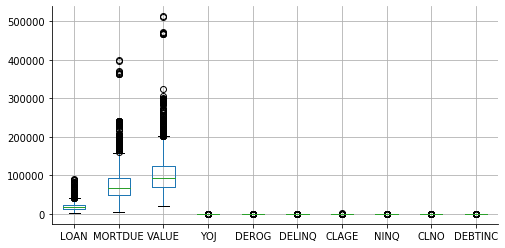

In [291]:
#verifico outliers

plt.figure(figsize=(8,4))
dataset.boxplot()
plt.plot()
sb.despine()

In [292]:
#Filtramos registros outliers considerando 3 veces la desviación estandar para la variable MORTDUE

outliers_MORTDUE = dataset[dataset.MORTDUE > (dataset.MORTDUE.mean() + 3 * dataset.MORTDUE.std())]
outliers_MORTDUE.shape


(34, 11)

In [293]:
#Filtramos registros outliers considerando 3 veces la desviación estandar para la variable VALUE

outliers_VALUE = dataset[dataset.VALUE > (dataset.VALUE.mean() + 3 * dataset.VALUE.std())]
outliers_VALUE.shape


(30, 11)

**Removemos los registros outliers para que no tengan impacto en los cálculos de los modelos**


In [294]:
dataset_limpio = dataset.drop(outliers_MORTDUE.index)

In [296]:
dataset_limpio = dataset.drop(outliers_VALUE.index)


In [297]:
dataset_limpio.shape

(1824, 11)

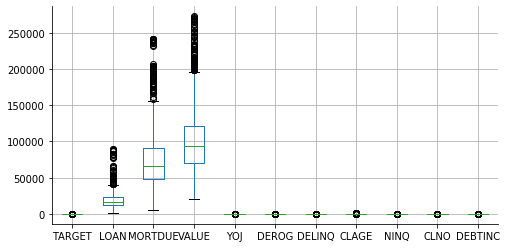

In [299]:
#verifico como quedó el data set sin ouliers

plt.figure(figsize=(8,4))
dataset_limpio.boxplot()
plt.plot()
sb.despine()

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

**División entre instancias y etiquetas**

In [949]:
X, y = dataset.iloc[:, 1:], dataset.TARGET

# Si se desea verificar el clasificador con las columnas más importantes
# X = X[['LOAN','MORTDUE','YOJ','DEBTINC', 'DELINQ']]

# división entre entrenamiento y evaluación (se utiliza el 80% de los datos para entrenamiento
# y 20% para evaluación)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


*Cantidad de registros obtenidos de la división*

In [950]:
X_train.shape[0], X_test.shape[0]

(1483, 371)

*Proporción de registros en train de cada clase*

In [951]:
y_train.value_counts()/y_train.shape[0]


0   0.8307
1   0.1693
Name: TARGET, dtype: float64

*Proporcion de registros en test de cada clase*

In [1151]:
y_test.value_counts()/y_test.shape[0]


0   0.8437
1   0.1563
Name: TARGET, dtype: float64

**Se instancia el modelo SGDClassifier con valores de hiperparametros default**

*El Descenso de gradiente estocástico es sensible al escalado de características, por lo que es muy recomendable escalar sus datos. Por ejemplo, escale cada atributo en el vector de entrada X a [0,1] o [-1, + 1],  o estandarícelo para que tenga media 0 y varianza 1*

(referencia: https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use)

In [953]:
# se normalinza los datos

ss = StandardScaler()
ss.fit(X_train)
ss.fit(X_test)

X_train_norm = ss.transform(X_train)
X_test_norm = ss.transform(X_test)

In [954]:
# instancio modelo SGDClassifier con semilla aleatoria fija en 0
model = SGDClassifier(random_state=0)

# entrenamos modelo
model.fit(X_train_norm,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

obtenemos el valor de las etiquetas de las clases obtenidas con los datos de train

In [955]:
y_train_pred = model.predict(X_train_norm)

obtenemos el valor de las etiquetas de las clases obtenidas con los datos de test

In [956]:
y_test_pred = model.predict(X_test_norm)

In [957]:
accuracy_score(y_test, y_test_pred)

0.8652291105121294

Creamos variables de metricas de SGDClassifier con valores default


In [958]:
SGDClassifier_default_train_accuracy_score = 0.0
SGDClassifier_default_train_precision_score = 0.0
SGDClassifier_default_train_recall_score = 0.0
SGDClassifier_default_train_f1_score = 0.0

SGDClassifier_default_test_accuracy_score = 0.0
SGDClassifier_default_test_precision_score = 0.0
SGDClassifier_default_test_recall_score = 0.0
SGDClassifier_default_test_f1_score = 0.0

In [959]:
SGDClassifier_default_train_accuracy_score = accuracy_score(y_train, y_train_pred)
SGDClassifier_default_train_precision_score = precision_score(y_train, y_train_pred)
SGDClassifier_default_train_recall_score = recall_score(y_train, y_train_pred)
SGDClassifier_default_train_f1_score = f1_score(y_train, y_train_pred)

SGDClassifier_default_test_accuracy_score = accuracy_score(y_test, y_test_pred)
SGDClassifier_default_test_precision_score = precision_score(y_test, y_test_pred)
SGDClassifier_default_test_recall_score = recall_score(y_test, y_test_pred)
SGDClassifier_default_test_f1_score = f1_score(y_test, y_test_pred)

In [960]:
print("---- metricas SGDClassifier DEFAULT -----")
print("=========================================")
print(f"-- train_accuracy_score: {SGDClassifier_default_train_accuracy_score} ")
print(f"-- test_accuracy_score:  {SGDClassifier_default_test_accuracy_score} ")
print("---------------------------------------- ")

print(f"-- train_precision_score:{SGDClassifier_default_train_precision_score} ")
print(f"-- test_precision_score: {SGDClassifier_default_test_precision_score} ")
print("---------------------------------------- ")

print(f"-- train_recall_score:   {SGDClassifier_default_train_recall_score} ")
print(f"-- test_recall_score:    {SGDClassifier_default_test_recall_score} ")
print("---------------------------------------- ")

print(f"-- train_f1_score:       {SGDClassifier_default_train_f1_score} ")
print(f"-- train_f1_score:       {SGDClassifier_default_test_f1_score} ")
      
print("-----------------------------------------")
            
      

---- metricas SGDClassifier DEFAULT -----
-- train_accuracy_score: 0.8651382333108564 
-- test_accuracy_score:  0.8652291105121294 
---------------------------------------- 
-- train_precision_score:0.6545454545454545 
-- test_precision_score: 0.6111111111111112 
---------------------------------------- 
-- train_recall_score:   0.4302788844621514 
-- test_recall_score:    0.3793103448275862 
---------------------------------------- 
-- train_f1_score:       0.5192307692307692 
-- train_f1_score:       0.46808510638297873 
-----------------------------------------


**Matriz de confusión**

In [961]:
# Matriz de datos de training
cm =confusion_matrix(y_train, y_train_pred)
cm


array([[1175,   57],
       [ 143,  108]])

In [962]:
# Matriz de datos de testing
cm =confusion_matrix(y_test, y_test_pred)
cm

array([[299,  14],
       [ 36,  22]])

**Reporte de clasificación para datos de test**


In [964]:
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.61      0.38      0.47        58

    accuracy                           0.87       371
   macro avg       0.75      0.67      0.70       371
weighted avg       0.85      0.87      0.85       371



*El clasificador con los hiperparametros por defectos tiene un presición del 84%. Clasifica muy bien la clase (0) con un buen porcentaje, pero la clase (1) no es muy confiable ya que a penena supera el 50%*

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

**Definimos la lista de hiperparametros a evaluar**

In [1002]:
param_grid = {
    'loss': ['hinge', 'log','squared_hinge'],
    'penalty': ['l2', 'l1',],
    'alpha': [.00001,.0001, .001],
    'learning_rate': ['constant','optimal','adaptive'],
    'eta0':[.0001]
}

In [1003]:
# instancio modelo con semilla aleatoria fija
model = SGDClassifier(random_state=0)
model_gscv = GridSearchCV(model,param_grid,scoring='precision',cv=5)

In [1004]:
model_gscv.fit(X_train_norm,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001], 'eta0': [0.0001],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['hinge', 'log', 'square

In [1029]:
results = model_gscv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("loss|penalty|alpha|max_iter|mean|std|rank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['loss']}|{p['penalty']}|{p['alpha']}|{p['learning_rate']}|{m:0.2f}|{s:0.2f}|{r}")


loss|penalty|alpha|max_iter|mean|std|rank
hinge|l2|1e-05|constant|0.89|0.03|6
hinge|l1|1e-05|constant|0.89|0.03|6
log|l2|1e-05|constant|0.81|0.08|26
log|l1|1e-05|constant|0.81|0.08|26
squared_hinge|l2|1e-05|constant|0.83|0.05|18
squared_hinge|l1|1e-05|constant|0.83|0.05|18
hinge|l2|1e-05|optimal|0.47|0.16|49
hinge|l1|1e-05|optimal|0.63|0.22|46
log|l2|1e-05|optimal|0.43|0.12|53
log|l1|1e-05|optimal|0.48|0.22|48
squared_hinge|l2|1e-05|optimal|0.42|0.11|54
squared_hinge|l1|1e-05|optimal|0.43|0.10|52
hinge|l2|1e-05|adaptive|0.89|0.03|2
hinge|l1|1e-05|adaptive|0.89|0.03|2
log|l2|1e-05|adaptive|0.81|0.08|26
log|l1|1e-05|adaptive|0.81|0.08|26
squared_hinge|l2|1e-05|adaptive|0.83|0.06|13
squared_hinge|l1|1e-05|adaptive|0.83|0.06|13
hinge|l2|0.0001|constant|0.89|0.03|6
hinge|l1|0.0001|constant|0.89|0.03|6
log|l2|0.0001|constant|0.81|0.08|26
log|l1|0.0001|constant|0.81|0.08|26
squared_hinge|l2|0.0001|constant|0.83|0.05|18
squared_hinge|l1|0.0001|constant|0.83|0.05|18
hinge|l2|0.0001|optimal|0.55

**Mejor modelo y parametro segun (scoring='precision')**

In [1031]:
model_gscv.best_params_

{'alpha': 0.001,
 'eta0': 0.0001,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'penalty': 'l1'}

In [1007]:
model_gscv.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l1', power_t=0.5, random_state=0, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

**Entrenamos el modelo con los mejores parámetro**

In [1032]:
model_best = model_gscv.best_estimator_

In [1033]:
model_best.fit(X_train_norm,y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l1', power_t=0.5, random_state=0, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

**Obtenemos el valor de las etiquetas de las clases obtenidas con los datos de train**

In [1034]:
y_train_pred = model_best.predict(X_train)
y_test_pred = model_best.predict(X_test)

Creamos variables de metricas de SGDClassifier con hiperparámetros modificados


In [1036]:
SGDClassifier_hiperparam_train_accuracy_score = 0.0
SGDClassifier_hiperparam_train_precision_score = 0.0
SGDClassifier_hiperparam_train_recall_score = 0.0
SGDClassifier_hiperparam_train_f1_score = 0.0

SGDClassifier_hiperparam_test_accuracy_score = 0.0
SGDClassifier_hiperparam_test_precision_score = 0.0
SGDClassifier_hiperparam_test_recall_score = 0.0
SGDClassifier_hiperparam_test_f1_score = 0.0


In [1038]:
SGDClassifier_hiperparam_train_accuracy_score = accuracy_score(y_train, y_train_pred)
SGDClassifier_hiperparam_train_precision_score = precision_score(y_train, y_train_pred)
SGDClassifier_hiperparam_train_recall_score = recall_score(y_train, y_train_pred)
SGDClassifier_hiperparam_train_f1_score = f1_score(y_train, y_train_pred)

SGDClassifier_hiperparam_test_accuracy_score = accuracy_score(y_test, y_test_pred)
SGDClassifier_hiperparam_test_precision_score = precision_score(y_test, y_test_pred)
SGDClassifier_hiperparam_test_recall_score = recall_score(y_test, y_test_pred)
SGDClassifier_hiperparam_test_f1_score = f1_score(y_test, y_test_pred)

In [1043]:
print("---- metricas SGDClassifier HIPERPARAMETROS -----")
print("=================================================")
print(f"-- train_accuracy_score: {SGDClassifier_hiperparam_train_accuracy_score} ")
print(f"-- test_accuracy_score:  {SGDClassifier_hiperparam_test_accuracy_score} ")
print("---------------------------------------- ")

print(f"-- train_precision_score:{SGDClassifier_hiperparam_train_precision_score} ")
print(f"-- test_precision_score: {SGDClassifier_hiperparam_test_precision_score} ")
print("---------------------------------------- ")

print(f"-- train_recall_score:   {SGDClassifier_hiperparam_train_recall_score} ")
print(f"-- test_recall_score:    {SGDClassifier_hiperparam_test_recall_score} ")
print("---------------------------------------- ")

print(f"-- train_f1_score:       {SGDClassifier_hiperparam_train_f1_score} ")
print(f"-- train_f1_score:       {SGDClassifier_hiperparam_test_f1_score} ")
      
print("-----------------------------------------")
            
      

---- metricas SGDClassifier HIPERPARAMETROS -----
-- train_accuracy_score: 0.6614969656102495 
-- test_accuracy_score:  0.6711590296495957 
---------------------------------------- 
-- train_precision_score:0.17060367454068243 
-- test_precision_score: 0.15217391304347827 
---------------------------------------- 
-- train_recall_score:   0.2589641434262948 
-- test_recall_score:    0.2413793103448276 
---------------------------------------- 
-- train_f1_score:       0.20569620253164558 
-- train_f1_score:       0.18666666666666665 
-----------------------------------------


**Matríz de confusión**

In [1040]:
# Matriz de datos de training
cmh =confusion_matrix(y_train, y_train_pred)
cmh


array([[916, 316],
       [186,  65]])

In [1041]:
# Matriz de datos de test
cmh =confusion_matrix(y_test, y_test_pred)
cmh

array([[235,  78],
       [ 44,  14]])

**Comparación entre los dos modelos**

In [1057]:
print("---- metricas COMPARACION------------------------")
print("=================================================")
print("")
print("--------------------------DEFAULT-----------------HIPERPARAMETRO-------- ")
print(f"-- train_accuracy_score: {SGDClassifier_default_train_accuracy_score}       {SGDClassifier_hiperparam_train_accuracy_score} ")
print(f"-- test_accuracy_score:  {SGDClassifier_default_test_accuracy_score}       {SGDClassifier_hiperparam_test_accuracy_score} ")
print("------------------------------------------------------------------------ ")

print(f"-- train_precision_score:{SGDClassifier_default_train_precision_score}       {SGDClassifier_hiperparam_train_precision_score}")
print(f"-- test_precision_score: {SGDClassifier_default_test_precision_score}       {SGDClassifier_hiperparam_test_precision_score}")
print("------------------------------------------------------------------------ ")

print(f"-- train_recall_score:   {SGDClassifier_default_train_recall_score}       {SGDClassifier_hiperparam_train_recall_score}")
print(f"-- test_recall_score:    {SGDClassifier_default_test_recall_score}       {SGDClassifier_hiperparam_test_recall_score}")
print("------------------------------------------------------------------------ ")

print(f"-- train_f1_score:       {SGDClassifier_hiperparam_train_f1_score}      {SGDClassifier_hiperparam_train_f1_score}")
print(f"-- train_f1_score:       {SGDClassifier_hiperparam_test_f1_score}      {SGDClassifier_hiperparam_test_f1_score}")
      
print("------------------------------------------------------------------------ ")
            

---- metricas SGDClassifier HIPERPARAMETROS -----

--------------------------DEFAULT-----------------HIPERPARAMETRO-------- 
-- train_accuracy_score: 0.8651382333108564       0.6614969656102495 
-- test_accuracy_score:  0.8652291105121294       0.6711590296495957 
------------------------------------------------------------------------ 
-- train_precision_score:0.6545454545454545       0.17060367454068243
-- test_precision_score: 0.6111111111111112       0.15217391304347827
------------------------------------------------------------------------ 
-- train_recall_score:   0.4302788844621514       0.2589641434262948
-- test_recall_score:    0.3793103448275862       0.2413793103448276
------------------------------------------------------------------------ 
-- train_f1_score:       0.20569620253164558      0.20569620253164558
-- train_f1_score:       0.18666666666666665      0.18666666666666665
------------------------------------------------------------------------ 


**Reporte de clasificación para datos de test**

In [1058]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       313
           1       0.15      0.24      0.19        58

    accuracy                           0.67       371
   macro avg       0.50      0.50      0.49       371
weighted avg       0.73      0.67      0.70       371



**Conclusión**

*Como se puede observar en la comparación de los modelos, los valores por defecto del SGDClassifier dieron mejor resultado que los ajustes de los hiperparámetros. El modelo propuesto como mejor el scoring='precision' empeora en cada métrica.*

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


**Se instancia el modelo DecisionTreeClassifier con valores de hiperparametros default**

In [1138]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_norm, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

obtenemos el valor de las etiquetas de las clases obtenidas con los datos de train

In [1140]:
y_train_pred = clf.predict(X_train_norm)
y_test_pred = clf.predict(X_test_norm)

Creamos variables de metricas de DecisionTreeClassifier con valores default

In [1142]:
DecisionTreeClassifier_default_train_accuracy_score = 0.0
DecisionTreeClassifier_default_train_precision_score = 0.0
DecisionTreeClassifier_default_train_recall_score = 0.0
DecisionTreeClassifier_default_train_f1_score = 0.0

DecisionTreeClassifier_default_test_accuracy_score = 0.0
DecisionTreeClassifier_default_test_precision_score = 0.0
DecisionTreeClassifier_default_test_recall_score = 0.0
DecisionTreeClassifier_default_test_f1_score = 0.0

In [1143]:
DecisionTreeClassifier_default_train_accuracy_score = accuracy_score(y_train, y_train_pred)
DecisionTreeClassifier_default_train_precision_score = precision_score(y_train, y_train_pred)
DecisionTreeClassifier_default_train_recall_score = recall_score(y_train, y_train_pred)
DecisionTreeClassifier_default_train_f1_score = f1_score(y_train, y_train_pred)

DecisionTreeClassifier_default_test_accuracy_score = accuracy_score(y_test, y_test_pred)
DecisionTreeClassifier_default_test_precision_score = precision_score(y_test, y_test_pred)
DecisionTreeClassifier_default_test_recall_score = recall_score(y_test, y_test_pred)
DecisionTreeClassifier_default_test_f1_score = f1_score(y_test, y_test_pred)

In [1144]:
print("---- metricas DecisionTreeClassifier DEFAULT -----")
print("=========================================")
print(f"-- train_accuracy_score: {DecisionTreeClassifier_default_train_accuracy_score} ")
print(f"-- test_accuracy_score:  {DecisionTreeClassifier_default_test_accuracy_score} ")
print("---------------------------------------- ")

print(f"-- train_precision_score:{DecisionTreeClassifier_default_train_precision_score} ")
print(f"-- test_precision_score: {DecisionTreeClassifier_default_test_precision_score} ")
print("---------------------------------------- ")

print(f"-- train_recall_score:   {DecisionTreeClassifier_default_train_recall_score} ")
print(f"-- test_recall_score:    {DecisionTreeClassifier_default_test_recall_score} ")
print("---------------------------------------- ")

print(f"-- train_f1_score:       {DecisionTreeClassifier_default_train_f1_score} ")
print(f"-- train_f1_score:       {DecisionTreeClassifier_default_test_f1_score} ")
      
print("-----------------------------------------")
            
      

---- metricas DecisionTreeClassifier DEFAULT -----
-- train_accuracy_score: 1.0 
-- test_accuracy_score:  0.8814016172506739 
---------------------------------------- 
-- train_precision_score:1.0 
-- test_precision_score: 0.6166666666666667 
---------------------------------------- 
-- train_recall_score:   1.0 
-- test_recall_score:    0.6379310344827587 
---------------------------------------- 
-- train_f1_score:       1.0 
-- train_f1_score:       0.6271186440677966 
-----------------------------------------


**Matríz de confusión**

In [1147]:
# Matriz de datos de training
cm =confusion_matrix(y_train, y_train_pred)
cm


array([[1232,    0],
       [   0,  251]])

In [1148]:
# Matriz de datos de training
cm =confusion_matrix(y_test, y_test_pred)
cm


array([[290,  23],
       [ 21,  37]])

**Reporte de clasificación para testing**

In [1150]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



Gráfico del arbol obtenido en modelo con valores default

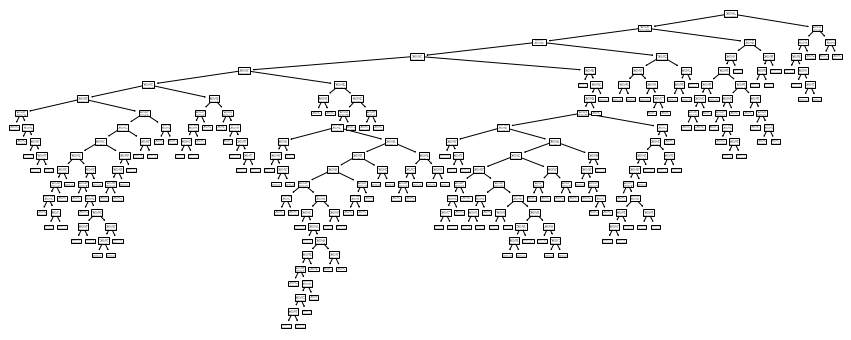

In [1153]:
plt.figure(figsize=(15,6))
plot_tree(clf);

El modelo da una presición del 100% en los datos de entranamiento. Por lo que se infiere que se realizó un overfitting

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

**Definimos la lista de hiperparametros a evaluar**

In [1154]:
param_grid = {
    'criterion': ['gini', 'entropy', ],
    'splitter': ['best', 'random',],
    'max_depth': [None,1,3,5,7,9,11,13,15, 17],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
}

In [1155]:
# los datos estan muy desbalanceandos, por lo que se usa un StratifiedKFold para se el cross validation
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)

# instancio modelo con semilla aleatoria fija
model = DecisionTreeClassifier(random_state=0)
model_gscv = GridSearchCV(model,param_grid,cv=skf)

In [1156]:
model_gscv.fit(X_train_norm, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy']

In [1170]:
results = model_gscv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

crit.	depth	| mean	std	rank
gini	None	| 0.85	0.02	132
gini	None	| 0.87	0.02	87
gini	None	| 0.86	0.02	112
gini	None	| 0.84	0.03	144
gini	None	| 0.86	0.02	112
gini	None	| 0.84	0.03	144
gini	None	| 0.86	0.02	112
gini	None	| 0.84	0.03	144
gini	1	| 0.87	0.01	78
gini	1	| 0.83	0.01	159
gini	1	| 0.87	0.01	78
gini	1	| 0.83	0.00	147
gini	1	| 0.87	0.01	78
gini	1	| 0.83	0.00	147
gini	1	| 0.87	0.01	78
gini	1	| 0.83	0.00	147
gini	3	| 0.88	0.01	24
gini	3	| 0.85	0.01	136
gini	3	| 0.87	0.01	50
gini	3	| 0.83	0.00	153
gini	3	| 0.87	0.01	50
gini	3	| 0.83	0.00	153
gini	3	| 0.87	0.01	50
gini	3	| 0.83	0.00	153
gini	5	| 0.87	0.01	46
gini	5	| 0.87	0.02	76
gini	5	| 0.88	0.01	13
gini	5	| 0.85	0.00	138
gini	5	| 0.88	0.01	13
gini	5	| 0.85	0.00	138
gini	5	| 0.88	0.01	13
gini	5	| 0.85	0.00	138
gini	7	| 0.88	0.02	23
gini	7	| 0.86	0.02	107
gini	7	| 0.87	0.01	57
gini	7	| 0.85	0.01	129
gini	7	| 0.87	0.01	57
gini	7	| 0.85	0.01	129
gini	7	| 0.87	0.01	57
gini	7	| 0.85	0.01	129
gini	9	| 0.88	0.02	12
gini	9	| 0.87	0.01	77
gi

**Mejor modelo y parametro**

In [1163]:
model_gscv.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'max_features': None,
 'splitter': 'random'}

In [1164]:
model_gscv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='random')

In [1165]:
best_model = model_gscv.best_estimator_

Obtenemos el valor de las etiquetas de las clases obtenidas con los datos de train

In [1166]:
y_train_pred = best_model.predict(X_train_norm)
y_test_pred = best_model.predict(X_test_norm)

Creamos variables de metricas de DecisionTreeClassifier con valores default

In [1167]:
DecisionTreeClassifier_hiperparam_train_accuracy_score = 0.0
DecisionTreeClassifier_hiperparam_train_precision_score = 0.0
DecisionTreeClassifier_hiperparam_train_recall_score = 0.0
DecisionTreeClassifier_hiperparam_train_f1_score = 0.0

DecisionTreeClassifier_hiperparam_test_accuracy_score = 0.0
DecisionTreeClassifier_hiperparam_test_precision_score = 0.0
DecisionTreeClassifier_hiperparam_test_recall_score = 0.0
DecisionTreeClassifier_hiperparam_test_f1_score = 0.0

In [1168]:
DecisionTreeClassifier_hiperparam_train_accuracy_score = accuracy_score(y_train, y_train_pred)
DecisionTreeClassifier_hiperparam_train_precision_score = precision_score(y_train, y_train_pred)
DecisionTreeClassifier_hiperparam_train_recall_score = recall_score(y_train, y_train_pred)
DecisionTreeClassifier_hiperparam_train_f1_score = f1_score(y_train, y_train_pred)

DecisionTreeClassifier_hiperparam_test_accuracy_score = accuracy_score(y_test, y_test_pred)
DecisionTreeClassifier_hiperparam_test_precision_score = precision_score(y_test, y_test_pred)
DecisionTreeClassifier_hiperparam_test_recall_score = recall_score(y_test, y_test_pred)
DecisionTreeClassifier_hiperparam_test_f1_score = f1_score(y_test, y_test_pred)

In [1169]:
print("---- metricas DecisionTreeClassifier HIPERPARAMETROS -----")
print("==========================================================")
print(f"-- train_accuracy_score: {DecisionTreeClassifier_hiperparam_train_accuracy_score} ")
print(f"-- test_accuracy_score:  {DecisionTreeClassifier_hiperparam_test_accuracy_score} ")
print("---------------------------------------- ")

print(f"-- train_precision_score:{DecisionTreeClassifier_hiperparam_train_precision_score}")
print(f"-- test_precision_score: {DecisionTreeClassifier_hiperparam_test_precision_score} ")
print("---------------------------------------- ")

print(f"-- train_recall_score:   {DecisionTreeClassifier_hiperparam_train_recall_score} ")
print(f"-- test_recall_score:    {DecisionTreeClassifier_hiperparam_test_recall_score} ")
print("---------------------------------------- ")

print(f"-- train_f1_score:       {DecisionTreeClassifier_hiperparam_train_f1_score} ")
print(f"-- train_f1_score:       {DecisionTreeClassifier_hiperparam_test_f1_score} ")
      
print("-----------------------------------------")

---- metricas DecisionTreeClassifier HIPERPARAMETROS -----
-- train_accuracy_score: 0.9325691166554282 
-- test_accuracy_score:  0.9029649595687331 
---------------------------------------- 
-- train_precision_score:0.9748427672955975
-- test_precision_score: 0.8666666666666667 
---------------------------------------- 
-- train_recall_score:   0.6175298804780877 
-- test_recall_score:    0.4482758620689655 
---------------------------------------- 
-- train_f1_score:       0.7560975609756098 
-- train_f1_score:       0.5909090909090909 
-----------------------------------------


**Matríz de confusión**

In [1172]:
# Matriz de datos de training
cm =confusion_matrix(y_train, y_train_pred)
cm


array([[1228,    4],
       [  96,  155]])

In [1173]:
# Matriz de datos de training
cm =confusion_matrix(y_test, y_test_pred)
cm

array([[309,   4],
       [ 32,  26]])

**Reporte de clasificación para datos de test**

In [1175]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94       313
           1       0.87      0.45      0.59        58

    accuracy                           0.90       371
   macro avg       0.89      0.72      0.77       371
weighted avg       0.90      0.90      0.89       371



**Gráfico de arbol obtenido**

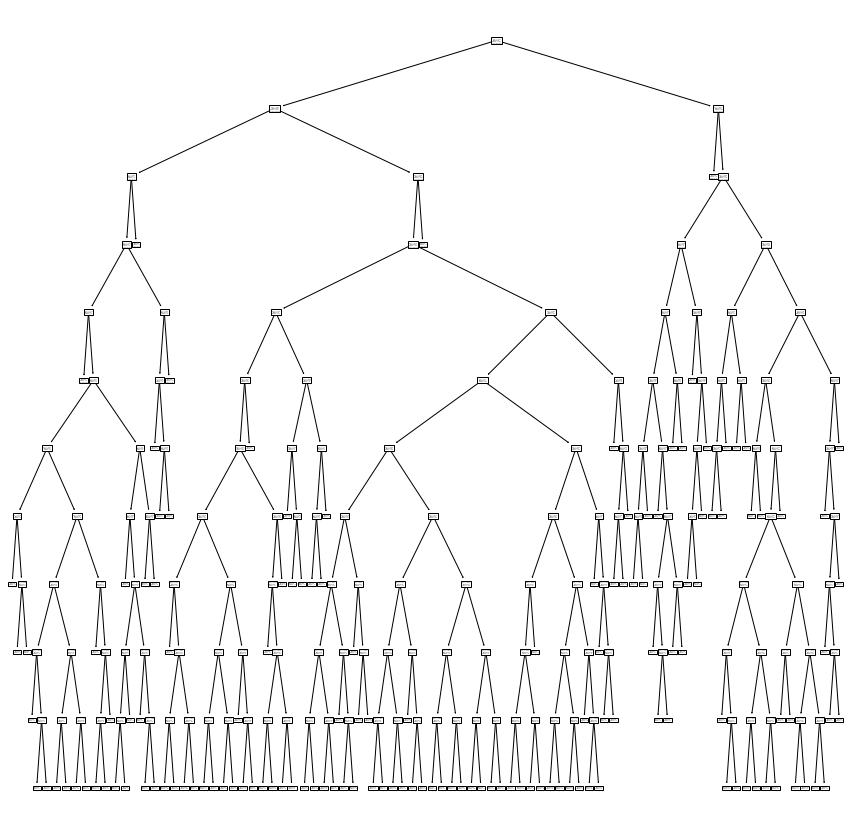

In [1178]:
plt.figure(figsize=(15,15))
plot_tree(model_clf);

**Comparación de modelos**

In [1201]:
print("---- metricas COMPARACION------------------------")
print("=================================================")
print("")
print("--------------------------DEFAULT-----------------HIPERPARAMETRO-------- ")
print(f"-- train_accuracy_score: {DecisionTreeClassifier_default_train_accuracy_score}                   {DecisionTreeClassifier_hiperparam_train_accuracy_score} ")
print(f"-- test_accuracy_score:  {DecisionTreeClassifier_default_test_accuracy_score}    {DecisionTreeClassifier_hiperparam_test_accuracy_score} ")
print("------------------------------------------------------------------------ ")

print(f"-- train_precision_score:{DecisionTreeClassifier_default_train_precision_score}                   {DecisionTreeClassifier_hiperparam_train_precision_score}")
print(f"-- test_precision_score: {DecisionTreeClassifier_default_test_precision_score}    {DecisionTreeClassifier_hiperparam_test_precision_score}")
print("------------------------------------------------------------------------ ")

print(f"-- train_recall_score:   {DecisionTreeClassifier_default_train_recall_score}                   {DecisionTreeClassifier_hiperparam_train_recall_score}")
print(f"-- test_recall_score:    {DecisionTreeClassifier_default_test_recall_score}    {DecisionTreeClassifier_hiperparam_test_recall_score}")
print("------------------------------------------------------------------------ ")

print(f"-- train_f1_score:       {DecisionTreeClassifier_default_train_f1_score}                   {DecisionTreeClassifier_hiperparam_train_f1_score}")
print(f"-- train_f1_score:       {DecisionTreeClassifier_default_test_f1_score}    {DecisionTreeClassifier_hiperparam_test_f1_score}")
      
print("------------------------------------------------------------------------ ")
            

---- metricas COMPARACION------------------------

--------------------------DEFAULT-----------------HIPERPARAMETRO-------- 
-- train_accuracy_score: 1.0                   0.9325691166554282 
-- test_accuracy_score:  0.8814016172506739    0.9029649595687331 
------------------------------------------------------------------------ 
-- train_precision_score:1.0                   0.9748427672955975
-- test_precision_score: 0.6166666666666667    0.8666666666666667
------------------------------------------------------------------------ 
-- train_recall_score:   1.0                   0.6175298804780877
-- test_recall_score:    0.6379310344827587    0.4482758620689655
------------------------------------------------------------------------ 
-- train_f1_score:       1.0                   0.7560975609756098
-- train_f1_score:       0.6271186440677966    0.5909090909090909
------------------------------------------------------------------------ 


**Conclusión**

*Comparando los modelos obetenidos por el arbol de desición, los ajustes a los hiperparámetros obtuvieron mejores resultados que los valores por defecto.
Con los valores por defecto, se ve que hay un overfitting teniendo 100% de presición en los datos de entrenamiento. Con el modelo propuesto por la búsqueda de mejores hiperparámetros se observa una mejor generalizción en el clasificador.*

*Por los valores indicados en las métricas el modelo de clasificación de arbol de desición (DecisionTreeClassifier)  ofrece mejores resultados que un clasificador por gradiente (SGDClassifier).*


